# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import string
import re
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from termcolor import colored

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()

from sentence_transformers import SentenceTransformer
s_model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

# Load survey data

In [2]:
# Read it in
path = "../data/surveys_clean_filtered.csv"
df = pd.read_csv(path, na_filter=False)

# Embed responses

In [14]:
# Select responses categorized as "about race"
df_race = df[df['about_race'] > 0]

# Group by race
df_race_black = df_race[df_race['racial_group'] == "black"]
df_race_white = df_race[df_race['racial_group'] == "white"]
df_race = pd.concat([df_race_black, df_race_white])

# Get long responses
res_race_black = df_race_black['long'].tolist()
res_race_white = df_race_white['long'].tolist()
res_race = df_race['long'].tolist()

## Method 1: Use entire response

In [4]:
# Transpose so each column is one response embedding
embed_race_black = np.transpose(s_model.encode(res_race_black))
embed_race_white = np.transpose(s_model.encode(res_race_white))
embed_race = np.concatenate((embed_race_black, embed_race_white), axis=1)

### Singular Values

In [5]:
def plot_singular_values():
    
    fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
    fig.suptitle(
        """Singular values of matrix of embeddings of 
        long responses categorized as 'about race'"""
    )
    
    skip = 0
    for A in [embed_race_black, embed_race_white, embed_race]:
        U,S,Vt = np.linalg.svd(A, full_matrices=False)
        S = [S[i]/S[0] for i in range(len(S))]
        axs[0].semilogy(S)
        if skip != 2:
            axs[1].semilogy(S)
        skip += 1
        
    axs[0].legend(["Black Responses", "White Responses", "All Responses"])
    axs[0].yaxis.set_tick_params(labelleft=True)
    
    axs[1].legend(["Black Responses", "White Responses"])
    axs[1].yaxis.set_tick_params(labelleft=True)

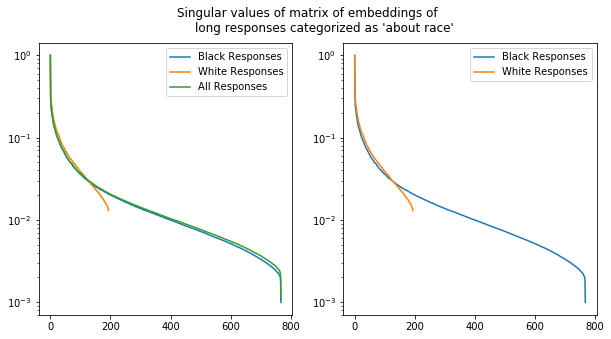

In [6]:
plot_singular_values()

### CUR Decomposition

In [7]:
def cur(A, idx=False, SVD=None, rank=None, p_C=None, p_R=None):
    
    if SVD==None:
        SVD = np.linalg.svd(A, full_matrices=False)
    if rank==None:
        rank = np.linalg.matrix_rank(A)
    
    V,S,Wt = SVD
    
    def DEIM(M, p=None): # row/column selection
        if not p:
            p = []
            p.append(np.argmax(np.abs(M[:,0]))) # row index of the largest value in the first column of M
        for i in range(len(p),rank):
            res = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(res)))
        return p
    
    p_C = DEIM(np.transpose(Wt), p_C)
    C = A[:,p_C]
    
    #p_R = DEIM(V, p_R)
    #R = A[p_R]
    
    #U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    
    return (C,p_C) if idx else C
    #return (C,U,R, p_C, p_R) if idx else (C,U,R)

In [8]:
C_race_black, p_C_race_black = cur(embed_race_black, idx=True)
C_race_white, p_C_race_white = cur(embed_race_white, idx=True)
C_race, p_C_race = cur(embed_race, idx=True)

### Are responses with more sentences given priority?

Text(0.5, 1.0, 'All Responses')

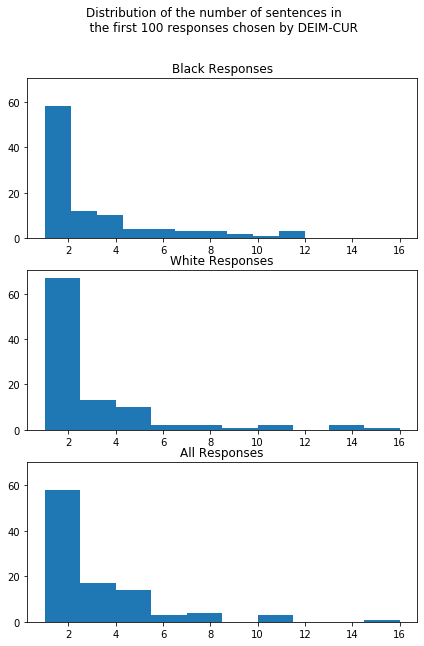

In [9]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(7,10))
fig.suptitle(
    """Distribution of the number of sentences in 
    the first 100 responses chosen by DEIM-CUR"""
)

list(filter(None, re.split("[.?!]", res_race_black[i].strip())))

axs[0].hist([
    len(list(filter(None, re.split("[.?!]", res_race_black[i].strip())))) 
    for i in p_C_race_black[:100]
])
axs[0].xaxis.set_tick_params(labelbottom=True)
axs[0].set_title("Black Responses")

axs[1].hist([
    len(list(filter(None, re.split("[.?!]", res_race_white[i].strip())))) 
    for i in p_C_race_white[:100]
])
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_title("White Responses")

axs[2].hist([
    len(list(filter(None, re.split("[.?!]", res_race[i].strip())))) 
    for i in p_C_race[:100]
])
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].set_title("All Responses")

### Error Plots

In [10]:
def plot_error(A, title, axs=None):
    V,S,Wt = np.linalg.svd(A, full_matrices=False)
    rank = np.linalg.matrix_rank(A)
    
    eta_c = np.zeros(rank)
    norm = np.zeros(rank)
    sig = np.zeros(rank)
    
    p_C_k = [] # track pre-selected columns from previous iterations
    
    A_k = np.zeros(A.shape)
    for k in range(rank):
        SVD_k = (V[:,:k+1],S[:k+1],Wt[:k+1,:])
        A_k = (SVD_k[0] * SVD_k[1][...,None,:]) @ SVD_k[2]
        C_k, p_C_k = cur(A_k, idx=True, SVD=SVD_k, rank=k+1, p_C=p_C_k)
        
        WtF_k = SVD_k[2][:k+1,:][:,p_C_k[:k+1]]
        eta_c[k] = np.linalg.norm(np.linalg.inv(WtF_k))
        
        X_k = np.linalg.pinv(C_k) @ A
        norm[k] = np.linalg.norm(A - C_k@X_k)
        
        sig[k] = np.linalg.norm(A - (SVD_k[0] * SVD_k[1][...,None,:]) @ SVD_k[2])
            
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    fig.suptitle(title)
    
    axs[0].scatter(range(rank), eta_c)
    axs[0].scatter(range(rank), norm)
    axs[0].scatter(range(1,rank+1), sig, marker='o', facecolors='none', edgecolors='r')
    axs[0].set(xlabel='k')
    axs[0].legend(["(eta_c)_k", "|| A - C_k(X_k) ||", "sigma_k"])
    
    axs[1].scatter(range(100), (norm[:100]-sig[:100])/sig[:100])
    axs[1].set(xlabel='k')
    axs[1].legend(["(|| A - C_k(X_k) || - sigma_(k+1)) / sigma_(k+1)"])

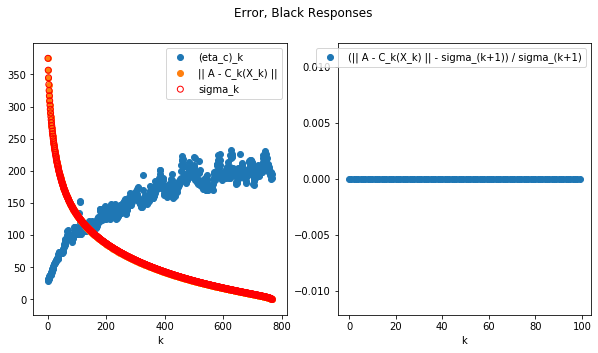

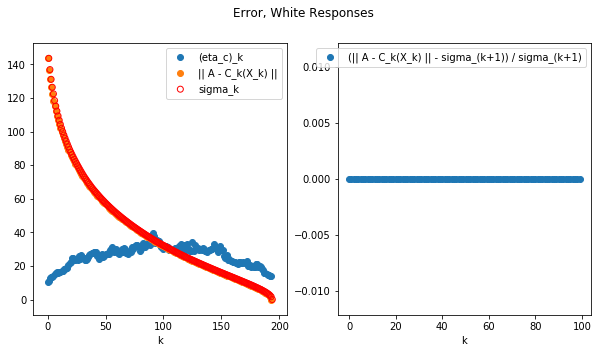

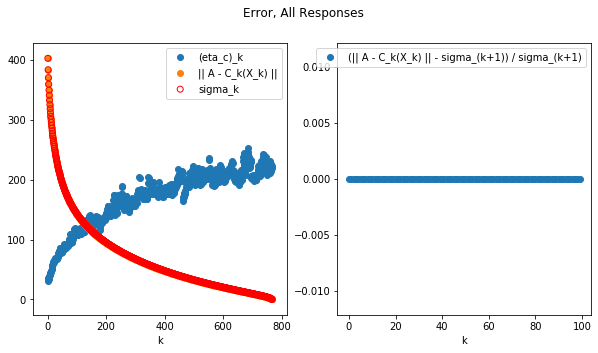

In [11]:
plot_error(embed_race_black, "Error, Black Responses")
plot_error(embed_race_white, "Error, White Responses")
plot_error(embed_race, "Error, All Responses")

## Method 2: Average the embeddings of each sentence

In [15]:
res_race_black_split = [
    list(filter(None, re.split("[.?!]", r.strip()))) 
    for r in res_race_black
]

embed_race_black = np.transpose([
    np.sum(s_model.encode(r), axis=0) / len(r)
    for r in res_race_black_split
])

res_race_white_split = [
    list(filter(None, re.split("[.?!]", r.strip()))) 
    for r in res_race_white
]

embed_race_white = np.transpose([
    np.sum(s_model.encode(r), axis=0) / len(r)
    for r in res_race_white_split
])

embed_race = np.concatenate((embed_race_black, embed_race_white), axis=1)

### Singular values

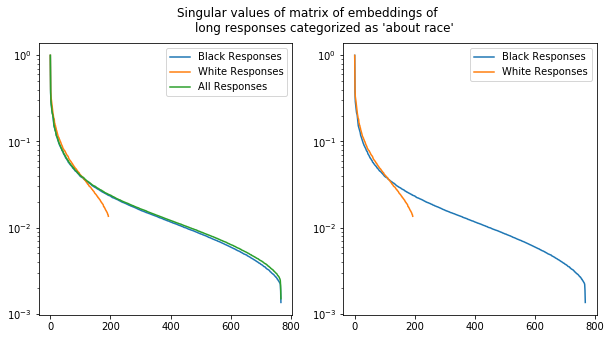

In [16]:
plot_singular_values()

### CUR Decomposition

In [17]:
C_race_black, p_C_race_black = cur(embed_race_black, idx=True)
C_race_white, p_C_race_white = cur(embed_race_white, idx=True)
C_race, p_C_race = cur(embed_race, idx=True)

### Are responses with more sentences given priority?

Text(0.5, 1.0, 'All Responses')

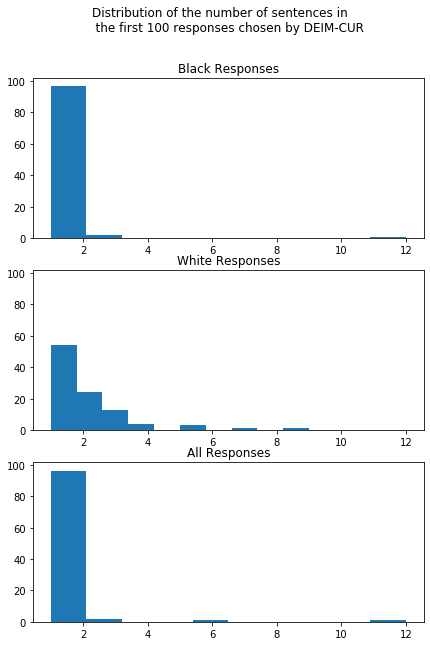

In [18]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(7,10))
fig.suptitle(
    """Distribution of the number of sentences in 
    the first 100 responses chosen by DEIM-CUR"""
)

axs[0].hist([
    len(list(filter(None, re.split("[.?!]", res_race_black[i].strip())))) 
    for i in p_C_race_black[:100]
])
axs[0].xaxis.set_tick_params(labelbottom=True)
axs[0].set_title("Black Responses")

axs[1].hist([
    len(list(filter(None, re.split("[.?!]", res_race_white[i].strip())))) 
    for i in p_C_race_white[:100]
])
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_title("White Responses")

axs[2].hist([
    len(list(filter(None, re.split("[.?!]", res_race[i].strip())))) 
    for i in p_C_race[:100]
])
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].set_title("All Responses")

### Error Plots

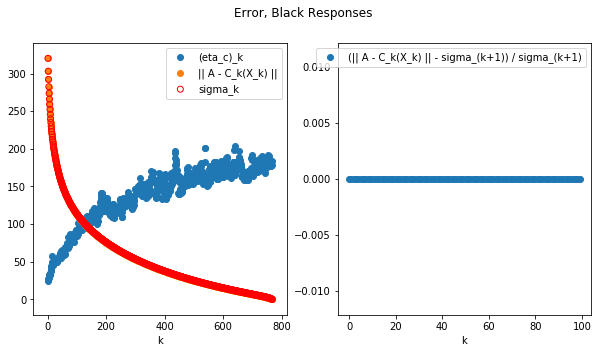

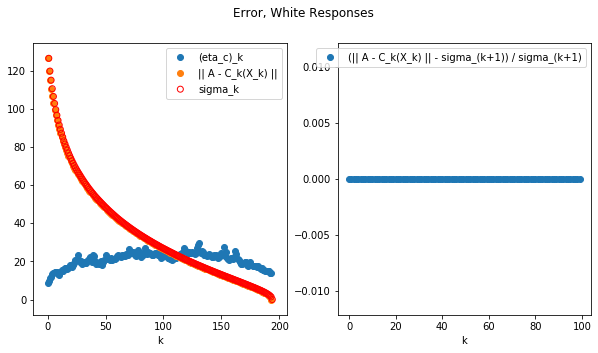

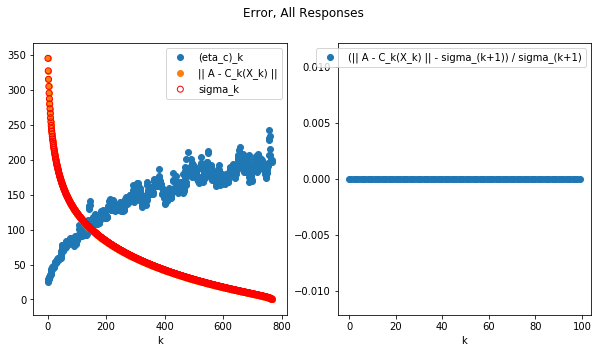

In [19]:
plot_error(embed_race_black, "Error, Black Responses")
plot_error(embed_race_white, "Error, White Responses")
plot_error(embed_race, "Error, All Responses")

## Method 3: Treat each sentence as separate response

In [64]:
# Split responses into sentences
res_race_black_split = [
    # remove leading/trailing whitespace from r
    # split sentences of r at punctuation
    # remove empty strings resulting from regex
    list(filter(None, re.split("[.?!]", r.strip())))
    for r in res_race_black
]

res_race_white_split = [
    list(filter(None, re.split("[.?!]", r.strip())))
    for r in res_race_white
]

# Flatten, storing original indices
res_race_black_split_flat = []
for i in range(len(res_race_black_split)): # Response index
    for j in range(len(res_race_black_split[i])): # Sentence index within response
        s = res_race_black_split[i][j]
        res_race_black_split_flat.append((i,j,s))
        
res_race_white_split_flat = []
for i in range(len(res_race_white_split)):
    for j in range(len(res_race_white_split[i])):
        s = res_race_white_split[i][j]
        res_race_white_split_flat.append((i+len(res_race_black),j,s))
        
res_race_split_flat = res_race_black_split_flat + res_race_white_split_flat

# Embed
embed_race_black = np.transpose(
    s_model.encode(
        [r[2] for r in res_race_black_split_flat]
    )
)

embed_race_white = np.transpose(
    s_model.encode(
        [r[2] for r in res_race_white_split_flat]
    )
)

embed_race = np.concatenate((embed_race_black, embed_race_white), axis=1)

### Singular values

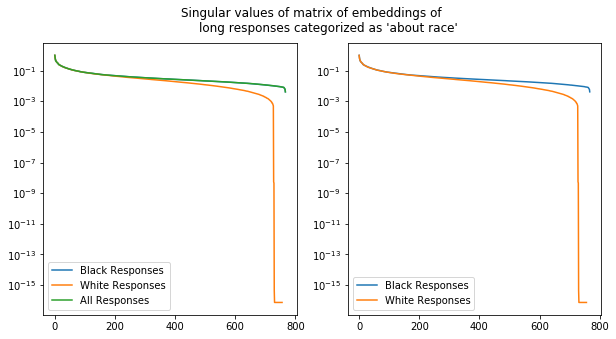

In [65]:
plot_singular_values()

### CUR Decomposition

In [66]:
C_race_black, p_C_race_black = cur(embed_race_black, idx=True)
C_race_white, p_C_race_white = cur(embed_race_white, idx=True)
C_race, p_C_race = cur(embed_race, idx=True)

### Are responses with more sentences given priority?

Text(0.5, 1.0, 'All Responses')

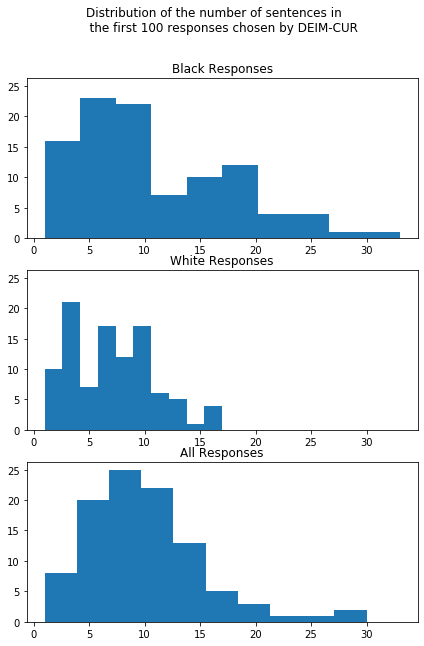

In [67]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(7,10))
fig.suptitle(
    """Distribution of the number of sentences in 
    the first 100 responses chosen by DEIM-CUR"""
)

axs[0].hist([
    len(list(filter(None, re.split("[.?!]", res_race[res_race_black_split_flat[i][0]].strip())))) 
    for i in p_C_race_black[:100]
])
axs[0].xaxis.set_tick_params(labelbottom=True)
axs[0].set_title("Black Responses")

axs[1].hist([
    len(list(filter(None, re.split("[.?!]", res_race[res_race_white_split_flat[i][0]].strip())))) 
    for i in p_C_race_white[:100]
])
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_title("White Responses")

axs[2].hist([
    len(list(filter(None, re.split("[.?!]", res_race[res_race_split_flat[i][0]].strip())))) 
    for i in p_C_race[:100]
])
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].set_title("All Responses")

### Highlight chosen sentences in the responses they appear

In [69]:
for i in p_C_race[:100]:
    sen = res_race_split_flat[i][2]
    res = res_race[res_race_split_flat[i][0]]
    race = df_race['racial_group'].iloc[res_race_split_flat[i][0]]
    print(colored(race, 'blue', attrs=['bold']))
    for s in list(filter(None, re.split("[.?!]", res.strip()))):
        if s == sen:
            print(colored(s, 'red', attrs=['bold']))
        else:
            print(s)
    print()

black
in order to make a soldier feel that he has something to fight for
 he should be near his home town or near some big city
 where he can see and realize what he must fight to try and hold
 to stop the ruff treatment of soldiers in southern states would help very much in every negro mind that he really has something to fight for if a man feels that he is being treated right
 he can do far better than if he thinks he is not
 it is hard to fight another country when we are fighting among our selves
 and trying to keep the darker race down because of color
 we the negro people are of different color
 but of the same material under neath as the white
 and if we are giving the chance we can do the same things which have been poorer in some cases
 lets stop putting white mp over colored soldiers
 and shooting and beating them

black
i don't like the comp
 here
 i don't like the peoples here
 i don't like the state here
 i don't like the transportation here
 i don't like the white peoples

1
 before i entered the army, i worked for and held a fairly important job in a defense plant; i have spent 8 months in the army doing exactly nothing and learning nothing 
 using a pick and shovel
 2
 i felt more loyalty to the country before i entered the army
 now i don't feel any loyalty after seeing the condition in the south
 3
 why should we get white southern officers that hate negro
 4
 n
c
o
's are selected in our co
 by their friends instead of ability
 i don't understand how the army expect us to follow a n
c
o
 that does not know what he is doing and some can not even read or write
 5
 the negro has not a thing to fight for
 6
 the negro soldier has  no recreation
 7
 negro soldier should never be placed in the south
 8
 we should have all negro officers
 9
 negro are usually placed in labor battalions
 10
 white civilians in the south hate negro soldiers and the negro soldier hates them

black
the negro feel they have something to fight for
 we dont want to be under any o

### Error plots

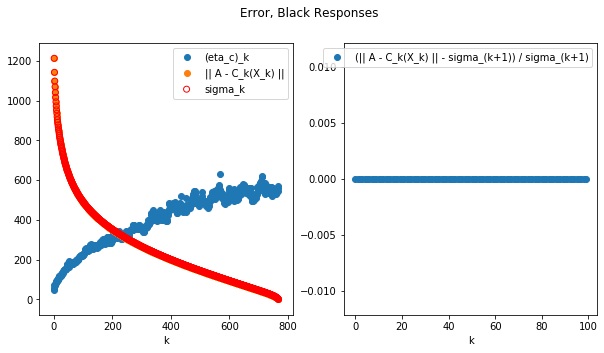

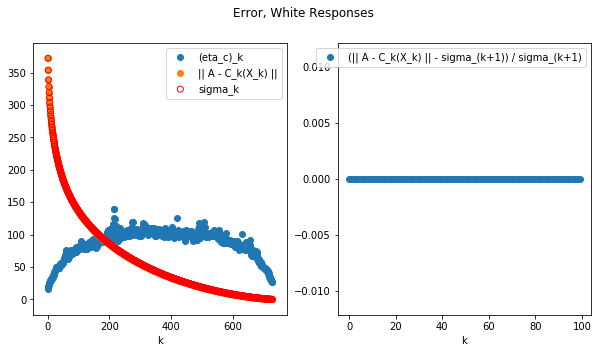

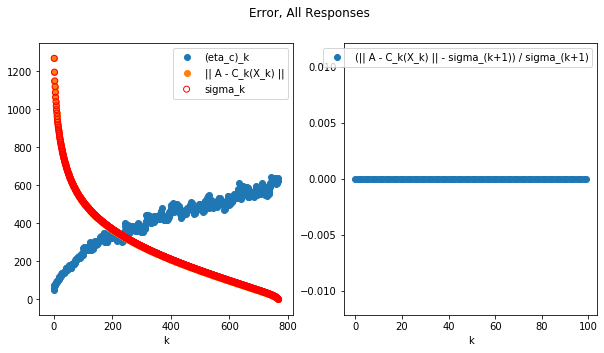

In [70]:
plot_error(embed_race_black, "Error, Black Responses")
plot_error(embed_race_white, "Error, White Responses")
plot_error(embed_race, "Error, All Responses")

## Method 4: Use the embeddings of the first 5 sentences as one large vector

In [71]:
def embed_5(r):
    embed_5 = []
    if len(r) == 1:
        embed_5 = s_model.encode(r*5)
    elif len(r) == 2:
        embed_5 = s_model.encode(r*2 + r[:1])
    elif len(r) == 3:
        embed_5 = s_model.encode(r + r[:2])
    elif len(r) == 4:
        embed_5 = s_model.encode(r + r[:1])
    else:
        embed_5 = s_model.encode(r[:5])
    return [item for sublist in embed_5 for item in sublist]

res_race_black_split = [
    list(filter(None, re.split("[.?!]", r.strip()))) 
    for r in res_race_black
]

res_race_white_split = [
    list(filter(None, re.split("[.?!]", r.strip()))) 
    for r in res_race_white
]

embed_race_black = np.transpose([embed_5(r) for r in res_race_black_split])
embed_race_white = np.transpose([embed_5(r) for r in res_race_white_split])

embed_race = np.concatenate((embed_race_black, embed_race_white), axis=1)

### Singular values

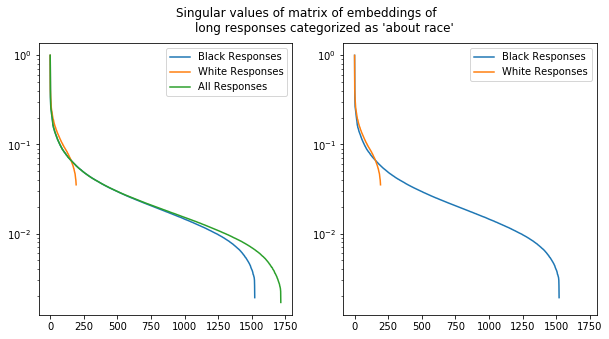

In [72]:
plot_singular_values()

### CUR Decomposition

In [73]:
C_race_black, p_C_race_black = cur(embed_race_black, idx=True)
C_race_white, p_C_race_white = cur(embed_race_white, idx=True)
C_race, p_C_race = cur(embed_race, idx=True)

### Are responses with more sentences given priority?

Text(0.5, 1.0, 'All Responses')

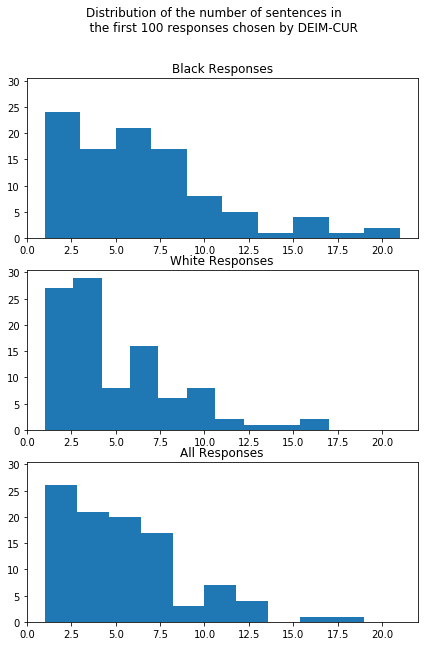

In [74]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(7,10))
fig.suptitle(
    """Distribution of the number of sentences in 
    the first 100 responses chosen by DEIM-CUR"""
)

axs[0].hist([
    len(list(filter(None, re.split("[.?!]", res_race_black[i].strip())))) 
    for i in p_C_race_black[:100]
])
axs[0].xaxis.set_tick_params(labelbottom=True)
axs[0].set_title("Black Responses")

axs[1].hist([
    len(list(filter(None, re.split("[.?!]", res_race_white[i].strip())))) 
    for i in p_C_race_white[:100]
])
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_title("White Responses")

axs[2].hist([
    len(list(filter(None, re.split("[.?!]", res_race[i].strip())))) 
    for i in p_C_race[:100]
])
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].set_title("All Responses")

### Error plots

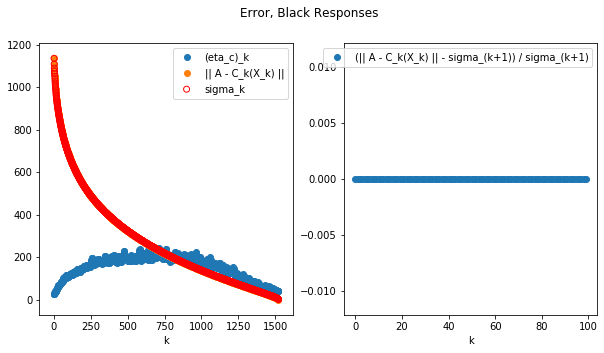

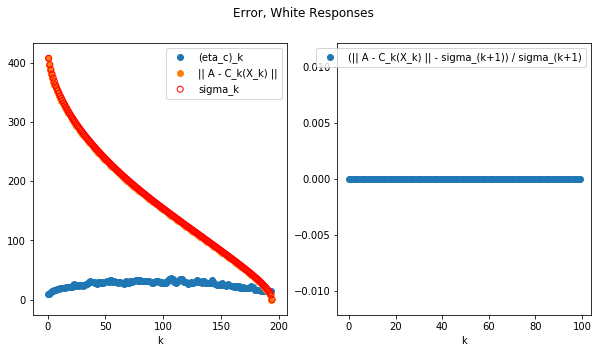

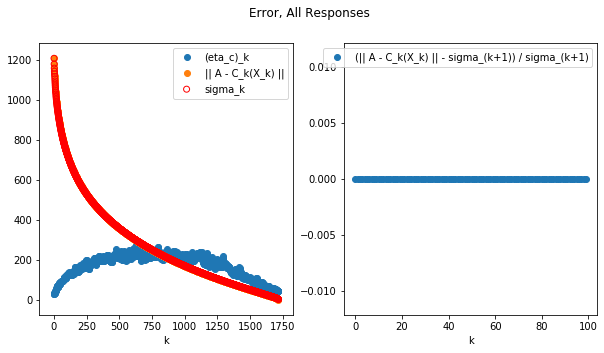

In [75]:
plot_error(embed_race_black, "Error, Black Responses")
plot_error(embed_race_white, "Error, White Responses")
plot_error(embed_race, "Error, All Responses")

## Method 3: Revisted

Filter further, using only the sentences having to do with race

In [76]:
def get_token_embeddings(text):
    
    # Tokenize the text
    split_text = text.split(". ")
    marked_text = "[CLS] " + " [SEP] ".join(split_text) + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)[:512] # Truncate if longer than 512
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # Mark tokens belonging to a sentence
    segment_ids = [0]*len(tokenized_text)
    is_zero = True
    for i in range(len(tokenized_text)):
        segment_ids[i] = 0 if is_zero else 1
        if tokenized_text[i] == "[SEP]":
            is_zero = not is_zero

    # Convert to torch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segment_ids])

    # Run through BERT
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

    # Adjust
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)

    # Get token vectors
    token_vecs_sum = []
    for token in token_embeddings:
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    
    return token_vecs_sum

In [77]:
# Use keyword in a short sentence/phrase for context
# NOTE: Pre-check the tokenization of each phrase.
#       Set 'idx' to the index of the keyword in the list of tokens
keys = [
    {"text": "The white man", "idx": 2, "embed": None},
    {"text": "The negro man", "idx": 2, "embed": None}
]

for k in keys:
    embed = get_token_embeddings(k['text'])
    k['embed'] = embed[k['idx']]

In [79]:
# Split responses into sentences
res_race_black_split = [
    # remove leading/trailing whitespace from r
    # split sentences of r at punctuation
    # remove empty strings resulting from regex
    list(filter(None, re.split("[.?!]", r.strip())))
    for r in res_race_black
]

res_race_white_split = [
    list(filter(None, re.split("[.?!]", r.strip())))
    for r in res_race_white
]                   

# Flatten, storing original indices
res_race_black_split_flat = []
for i in range(len(res_race_black_split)): # Response index
    for s in res_race_black_split[i]:
        res_race_black_split_flat.append((i,s))
        
res_race_white_split_flat = []
for i in range(len(res_race_white_split)):
    for s in res_race_white_split[i]:
        res_race_white_split_flat.append((i+len(res_race_black),s))
        
# Filter
for r in res_race_black_split_flat:
    keep = False
    embed = get_token_embeddings(r[1])
    for i in range(len(embed)):
        for k in keys:
            sim = 1 - cosine(embed[i], k['embed'])
            if sim >= 0.5:
                keep = True
                break
        if keep:
            break
    if not keep:
        res_race_black_split_flat.remove(r)
        
# Filter
for r in res_race_white_split_flat:
    keep = False
    embed = get_token_embeddings(r[1])
    for i in range(len(embed)):
        for k in keys:
            sim = 1 - cosine(embed[i], k['embed'])
            if sim >= 0.5:
                keep = True
                break
        if keep:
            break
    if not keep:
        res_race_white_split_flat.remove(r)
        
res_race_split_flat = res_race_black_split_flat + res_race_white_split_flat

# Embed
embed_race_black = np.transpose(
    s_model.encode(
        [r[1] for r in res_race_black_split_flat]
    )
)

embed_race_white = np.transpose(
    s_model.encode(
        [r[] for r in res_race_white_split_flat]
    )
)

embed_race = np.concatenate((embed_race_black, embed_race_white), axis=1)

### Singular values

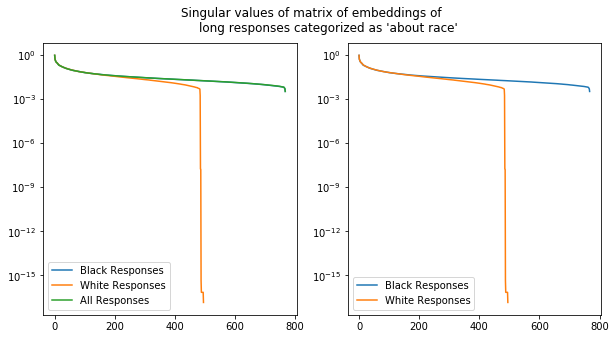

In [80]:
plot_singular_values()

### CUR Decomposition

In [81]:
C_race_black, p_C_race_black = cur(embed_race_black, idx=True)
C_race_white, p_C_race_white = cur(embed_race_white, idx=True)
C_race, p_C_race = cur(embed_race, idx=True)

### Are responses with more sentences given priority?

Text(0.5, 1.0, 'All Responses')

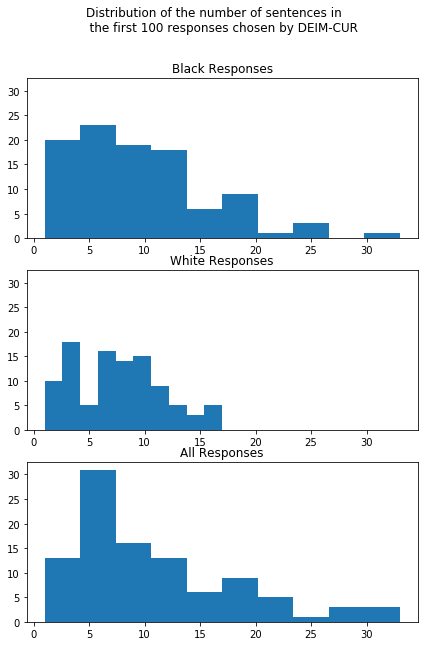

In [82]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(7,10))
fig.suptitle(
    """Distribution of the number of sentences in 
    the first 100 responses chosen by DEIM-CUR"""
)

axs[0].hist([
    len(list(filter(None, re.split("[.?!]", res_race[res_race_black_split_flat[i][0]].strip())))) 
    for i in p_C_race_black[:100]
])
axs[0].xaxis.set_tick_params(labelbottom=True)
axs[0].set_title("Black Responses")

axs[1].hist([
    len(list(filter(None, re.split("[.?!]", res_race[res_race_white_split_flat[i][0]].strip())))) 
    for i in p_C_race_white[:100]
])
axs[1].xaxis.set_tick_params(labelbottom=True)
axs[1].set_title("White Responses")

axs[2].hist([
    len(list(filter(None, re.split("[.?!]", res_race[res_race_split_flat[i][0]].strip())))) 
    for i in p_C_race[:100]
])
axs[2].xaxis.set_tick_params(labelbottom=True)
axs[2].set_title("All Responses")

### Highlight chosen sentences in the responses they appear

In [84]:
for i in p_C_race[:100]:
    sen = res_race_split_flat[i][1]
    res = res_race[res_race_split_flat[i][0]]
    race = df_race['racial_group'].iloc[res_race_split_flat[i][0]]
    print(colored(race, 'blue', attrs=['bold']))
    for s in list(filter(None, re.split("[.?!]", res.strip()))):
        if s == sen:
            print(colored(s, 'red', attrs=['bold']))
        else:
            print(s)
    print()

black
i think negro soldiers should be treated like any white soldier in the south it is different because most of the white people do not treat the negro fair in most cases

black
the theater the white soldiers have it jim crowed
 we are in the army for the same thing they are
 so we are entitled to the same thing
 they think because we are negro they can do like they want to
 they do not give us the right treatment  gives us a hard way to go as far as they are concern
 the officers are not giving us a chance like they should

black
reference to no
 68 -- we have all negro lieutenants in our company including the company commander
 but why isn't fort hauchuca an all negro unit as promised
 the 372nd is an all negro unit
 some white officers are all right, but negro function more satisfactory under a negro
 they understand one another

black
i dont have any comments to make because it does  help and   the other the way  feel about  but so for my outfit i am proud to be in it but i am s

 if a  southern  civilian had beat me and my friend that could be expected
 but when when 15 men who wear the same uniform as you do, who are suppose to be fighting for the same thing as you are, beat you inside of a jail with majors and captains and lieutenants actually looking on and not stopping them, it is time for any reasonable man to stop and ask himself what the hell is the negro fighting for

black
all i hope in time to calm the nation will be as one in peace time as it is when a war has to be won
 it will be one of the wellwords can't express it but if we were all taught to live together
 you could mention united states and mean united and the enemy would jump for there holes
 be united as one teach the ones that look don't lynch them
 give the negro a chance and you'll be surprised what you have in the country
 most of the way negro acts is because of the deserted part of the country, and thats the south
 otherwise you have to find a man as is ever breathed
 would think it o

### Error plots

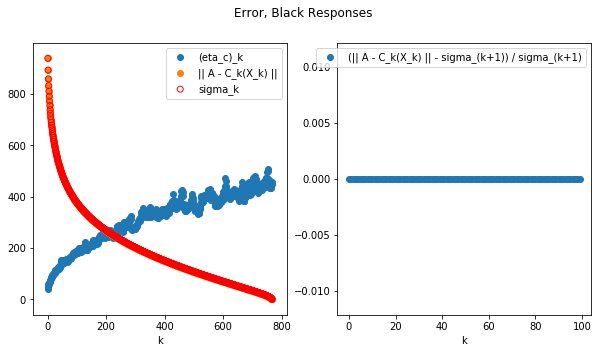

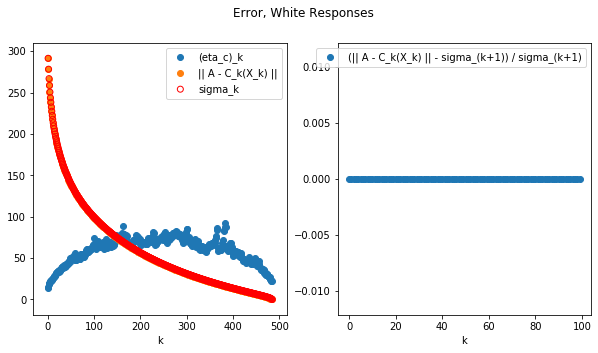

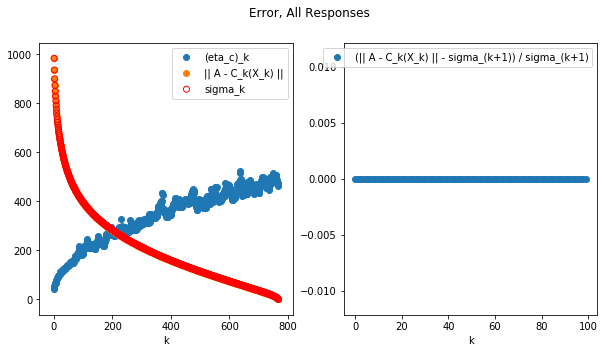

In [85]:
plot_error(embed_race_black, "Error, Black Responses")
plot_error(embed_race_white, "Error, White Responses")
plot_error(embed_race, "Error, All Responses")